# Project for: UC3M Class - Optimization and Decision Analytics
Author: Simon Schmetz

*Disclaimer*

This project was performed with a specific set of requirements at hand. None the less, an attempt was made to set up an intreguing problem with real world relevance, which at times led to some complications in fullfilling some of the requirements. More specifically, the requirement "Solving and implementing the dual for the continious problem" could not be successfully completed.

Furthermore some of the requirements are not fulfilled in the specific order as listed in the project requirements, but were attributed to the problem that was better fit to investigate the specific question of the requirement. 


In [114]:
### Imports
# Plotting
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Math
import math
import random
import numpy as np
import random
import statistics

# Utils
import time

# Pyomo
from pyomo.environ import *

# Sys Setup
random.seed(42)


As the final project for the course "optimization and decision analytics" for the Master in Statistics for  Data Science at the Universidad Carlos III, this project work has the goal to find a optimal distribution of space-train routes between a set of nodes. Between these nodes (each node and each every other node), there is a specific daily amount of demand of unitless "space cargo", that has to be fulfilled on a daily basis. 

To define the demand, we define three types of node: 

- Small nodes
- Medium nodes
- Main nodes

Representing difference smaller and bigger cities/centers and respectively bigger and smaller demands.

In [115]:
### Set up Node number and Position

# Number of nodes
n_nodes = 20

# Create a list for connections
nodes = range(1, n_nodes+1)
routes = [(m, n) for m in nodes for n in nodes if m != n]

# Manually specified positions of nodes 
positions = {
    1: (2, 10),  
    2: (3, 13),
    3: (5, 12),
    4: (6, 15),
    5: (8, 13),   
    6: (8, 9),   
    7: (11, 14),
    8: (13, 12), 
    9: (15, 10),
    10: (11, 9),
    11: (2, 7),
    12: (3, 4),
    13: (5, 7),  
    14: (6, 3),
    15: (8, 5), 
    16: (10, 6),
    17: (11, 6),
    18: (13, 5),
    19: (15, 3),
    20: (17, 5)
}

# Define main & medium nodes
main_nodes = {4, 5, 7, 12, 17}
medium_nodes = {9, 15, 13, 1, 8}

The demand (not yet specified) for each node to every other node is plotted in the following.

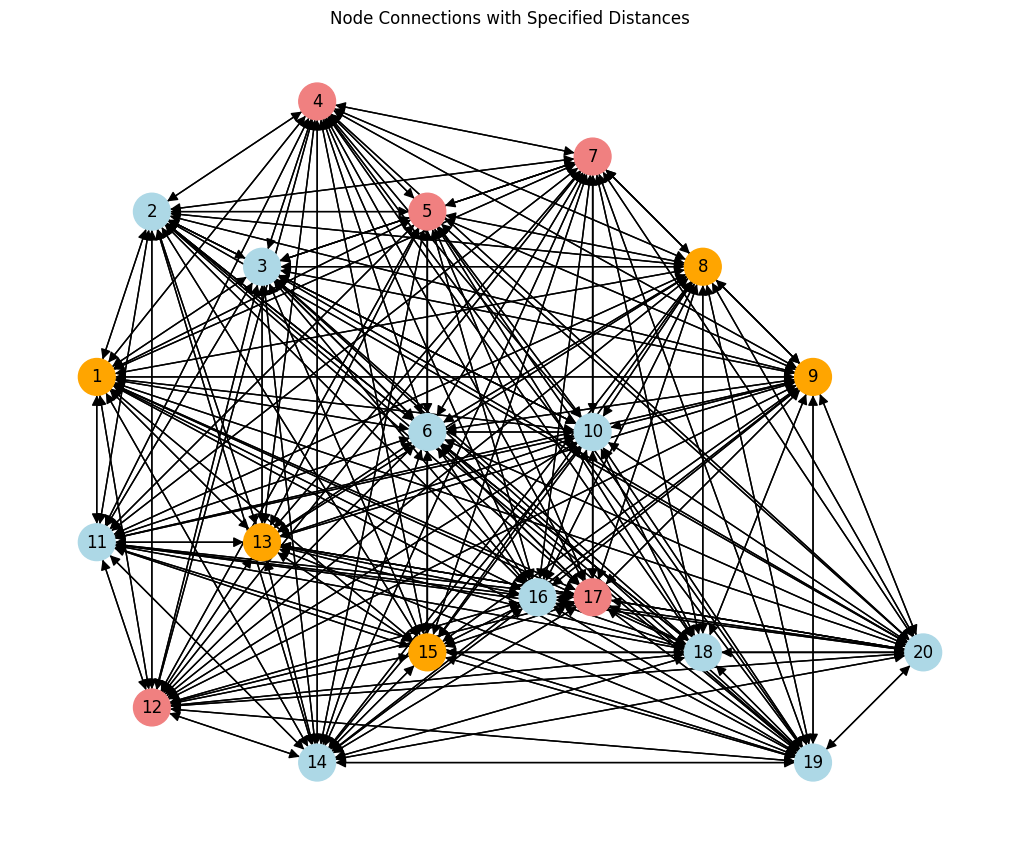

In [116]:
### Plot Node and demands to every other node
# Create a directed graph
G = nx.DiGraph()

# Add edges from the connections list
G.add_edges_from(routes)

# Plot Network
plt.figure(figsize=(10, 8))
node_colors = ['lightcoral' if node in main_nodes else 'orange' if node in medium_nodes else 'lightblue' for node in G.nodes()]
node_color_dict = {node: color for node, color in zip(G.nodes(), node_colors)}

nx.draw(G, pos=positions, with_labels=True, node_size=700, node_color=node_colors, arrowsize=15)
plt.title("Node Connections with Specified Distances")
plt.show()


To generate the demands, values are drawn from a normal distribution and multiplied with constants to account for node type.

In [117]:
### Make Demand

# Create a list of demands (randomly generated for illustration)
demands = [random.randint(200, 400) for _ in range(len(routes))]

# Create a dictionary for connection demands
connections_demand = {}
for connection, demand in zip(routes, demands):
    if connection[0] in main_nodes or connection[1] in main_nodes:
        demand *= 4  # Multiply demand for main nodes
    if connection[0] in medium_nodes or connection[1] in medium_nodes:
        demand *= 2  # Multiply demand for medium nodes
    connections_demand[connection] = demand  # Store connection and its demand in the dictionary

Furthermore, the lines are limited to a given set of routes that represent "space tracks" along which the space trains can move. These are defined as a adjencency Matrix. 

In [118]:
routes = [
    #1 #2 #3 #4 #5 #6 #7 #8 #9 #10#11#12#13#14#15#16#17#18#19#20
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], #1
    [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #2
    [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #3
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #4
    [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #5
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0], #6
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #7
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #8
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], #9
    [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], #10
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], #11
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0], #12
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0], #13
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0], #14
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], #15
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], #16
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], #17
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0], #18
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], #19
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], #20
]

# Function to calculate the Euclidean distance between two points
def euclidean_distance(pos1, pos2):
    return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)



# Iterate through all pairs of nodes
connections = []
for i in range(len(routes)):
    for j in range(len(routes[i])):
        if routes[i][j] == 1:  # Check for a connection
            connections.append((i + 1, j + 1))  # Add 1 to make it 1-based indexing




To evaluate cost at a later stage in the model_train_number_train_numberling process, the eucledian distances between the connected nodes are collected.

In [119]:
# Create a distance matrix and fill it with NaN where nodes are not connected
n = len(positions)
distance_matrix = np.full((n, n), np.inf)

for i in range(n):
    for j in range(n):
        if routes[i][j] == 1:
            pos_i = positions[i + 1]
            pos_j = positions[j + 1]
            distance_matrix[i][j] = euclidean_distance(pos_i, pos_j)


# Create a new dictionary for edge labels (distances)
edges = {}
for i in nodes:
    for j in nodes:
        if routes[i-1][j-1] == 1:
            edges[(i, j)] = float(round(distance_matrix[i-1][j-1], 2))  # +1 to match 1-indexing



Node connections (arcs) and arc lengths together are shown in the following plot.

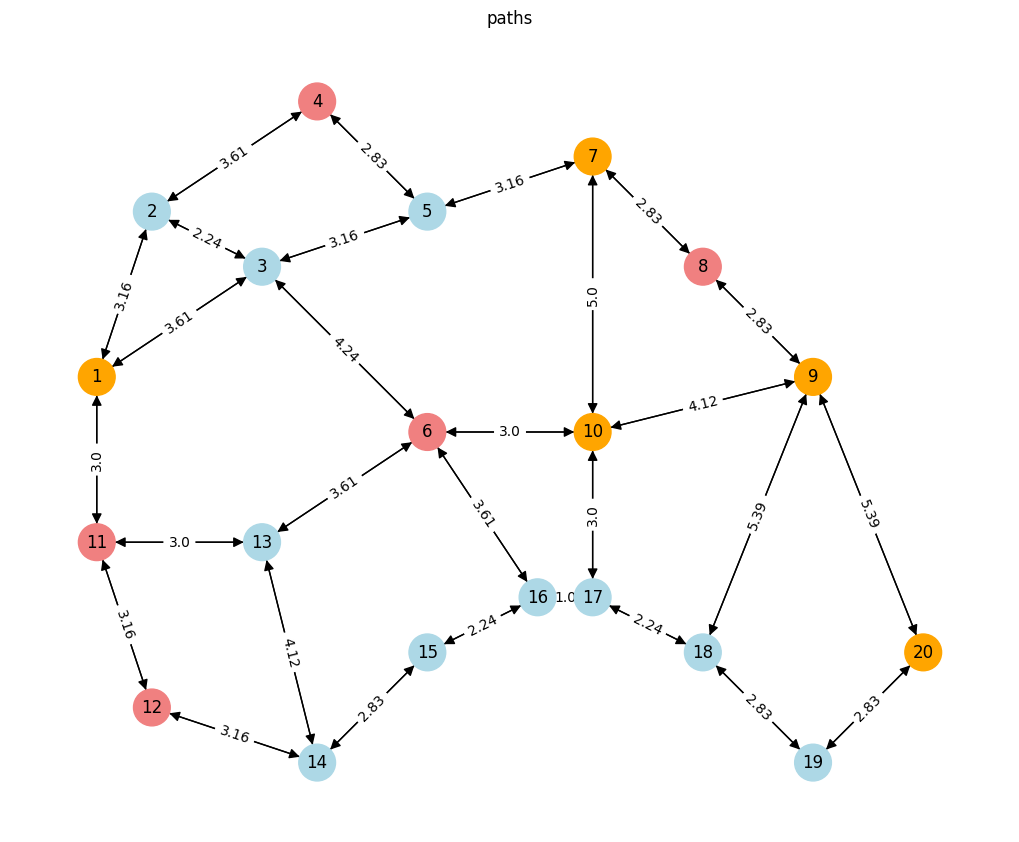

In [120]:
# Plot
G_closest = nx.DiGraph()
G_closest.add_edges_from(connections)

plt.figure(figsize=(10, 8))
nx.draw(G_closest, pos=positions, with_labels=True, node_size=700, node_color=node_colors, arrowsize=15)
nx.draw_networkx_edge_labels(G_closest, pos=positions, edge_labels=edges, font_size=10)

plt.title("paths")
plt.show()

Having established the given system of nodes, their arcs and having generated demands inbetween different nodes - the goal of this project will now be to establish some sort of system for space-train lines that satisfies the maximum possible demand inbetween all nodes. To simplify this fairly complicated problem, as an intitial step, the node-to-node demand will be calculated down to arc demands via repeatetly solving a shortest path problem. This means, that with the assumption that for every node to node demand taking the shortest path between the two will be most efficient, a demmand connecting Node A and Node B will be added to all arcs that are components of the shortest path connecting both node A and B. Doing so will simplify the problem of fullfilling all node to node demands to fullfilling all arc demands. 

## Problem 1 - Shortest Path to generate Arc Demands

As detailed in the setup of the problem, the first part of this project consists of solving $n\times n$ shortest path problems move demands from node to node to respective arcs of the shortest path. In simple terms, this means, to start with all arcs having demand=0, progressively solving shortest path problems inbetween all nodes and adding the demand of inbetween the two nodes to every arc that is part of the shortest path inbetween these two nodes. Doing so, the transport capacity required for each individual arc is calculated assuming all node-to-node demands are fullfilled via their shortest path.

### Mathematical Modelling

The mathematical model consist out of a subjective function that tries to minimize the absolut distance of the shortest path and conditions regarding flow continuity.

The objective function is written as: 
$$
\min \sum_{i,j \in arcs}^{n}c_{i,j}\cdot x_{i,j} \\
$$

with:
- $c_{i,j}$ as the cost, e.g. the eucledian distance between two given nodes´
- $x_{i,j}$ as the decision variable, e.g. whether a given arc is part of the shortest path or not

In addition to the objective function, two types of flow continuity constraints are required. Where the first one garantuees that every flow that enters a node also leaves the same node, with the exception for the start or end node, and the second two respectively covering the cases of start and end nodes where for start nodes only one flow unit can leave the node and none can enter and vice versa for the end node.

$$
\text{s.t.} 
\sum_{i,j \in arcs}^{n} x_{i,j} - \sum_{i,j \in arcs}^{n} x_{j,i} = 0 \text{ if i,j are not start or end node} \\  
\sum_{i,j \in arcs}^{n} x_{start,j} - \sum_{i,j \in arcs}^{n} x_{j,start} = 1\\
\sum_{i,j \in arcs}^{n} x_{i,end} - \sum_{i,j \in arcs}^{n} x_{end,i} = 1\\
$$


### Implementation
This optimization problem with its objective function and the corresponding constraints is implemented in the following piece of code in the form of a methode, to enable running it repeately. 

In [121]:
from pyomo.environ import *

# calculate shortest path function
def shortest_path(model, 
                  source,
                  destination,
                  node_positions,
                  arcs,
                  cost,
                  node_colors="blue",
                  bool_print=False,
                  plot_bool=False,
                  edgelabel_bool=True,
                  x_var_type = NonNegativeReals):
    

    model.source = source
    model.destination = destination

    model.nodes = Set(initialize=list(node_positions.keys())) 
    model.arcs = Set(within=model.nodes*model.nodes, initialize=arcs)
    model.cost = Param(model.arcs, initialize=cost)

    model.x = Var(model.arcs, domain=x_var_type)

    # obj function
    def obj_rule(model):
        return sum(model.cost[i, j] * model.x[i, j] for (i, j) in model.arcs)
    model.obj = Objective(rule=obj_rule, sense=minimize)

    # Constraint
    def flow_conservation_rule(model, node):
        if node == model.source:  # Source node
            return (sum(model.x[node, j] for j in model.nodes if (node, j) in model.arcs) - (sum(model.x[i, node] for i in model.nodes if (i, node) in model.arcs))  == 1)
        elif node == model.destination:  # Destination node
            return (sum(model.x[j, node] for j in model.nodes if (j, node) in model.arcs) - sum(model.x[node, i] for i in model.nodes if (node, i) in model.arcs)  == 1)
        else:
            return ((sum(model.x[i, node] for i in model.nodes if (i, node) in model.arcs) == sum(model.x[node, j] for j in model.nodes if (node, j) in model.arcs)))
    model.flow_conservation = Constraint(model.nodes, rule=flow_conservation_rule)

    # Solve the model with timer
    start_time = time.time()

    solver = SolverFactory('glpk')
    solver.solve(model)

    end_time = time.time()
    solving_time = end_time - start_time # in seconds
    
    ### Results and plots
    shortest_path_result = {}
    if bool_print: 
        print("length of shortest path: ", value(model.obj))
        print("Shortest Path Route (not sorted):")
        
    for (i, j) in model.arcs:
        if model.x[i, j].value != 0:
            shortest_path_result[(i, j)] = model.x[i, j].value
            if bool_print: 
                print(f"x[{i},{j}]")

    # Plot
    if plot_bool:
        G_closest = nx.DiGraph()
        G_closest.add_edges_from(arcs)

        plt.figure(figsize=(10, 8))
        nx.draw(G_closest, pos=node_positions, with_labels=True, node_size=700, node_color=node_colors, arrowsize=15)
        edgelabel_bool and nx.draw_networkx_edge_labels(G_closest, pos=node_positions, edge_labels=cost, font_size=10)
        nx.draw_networkx_edges(G_closest, pos=node_positions, edgelist=shortest_path_result, edge_color='lightcoral', width=7)

        plt.title("paths")
        plt.show()
        
    return shortest_path_result, model, solving_time


The function can be called with the corresponding parameters for any set of nodes and arcs and choosing any source and destination nodes. In the following code chunk, it is called for two nodes and a resulting shortest path is caldulated including a visualization. 

length of shortest path:  14.969999999999999
Shortest Path Route (not sorted):
x[1,3]
x[3,6]
x[6,10]
x[10,9]


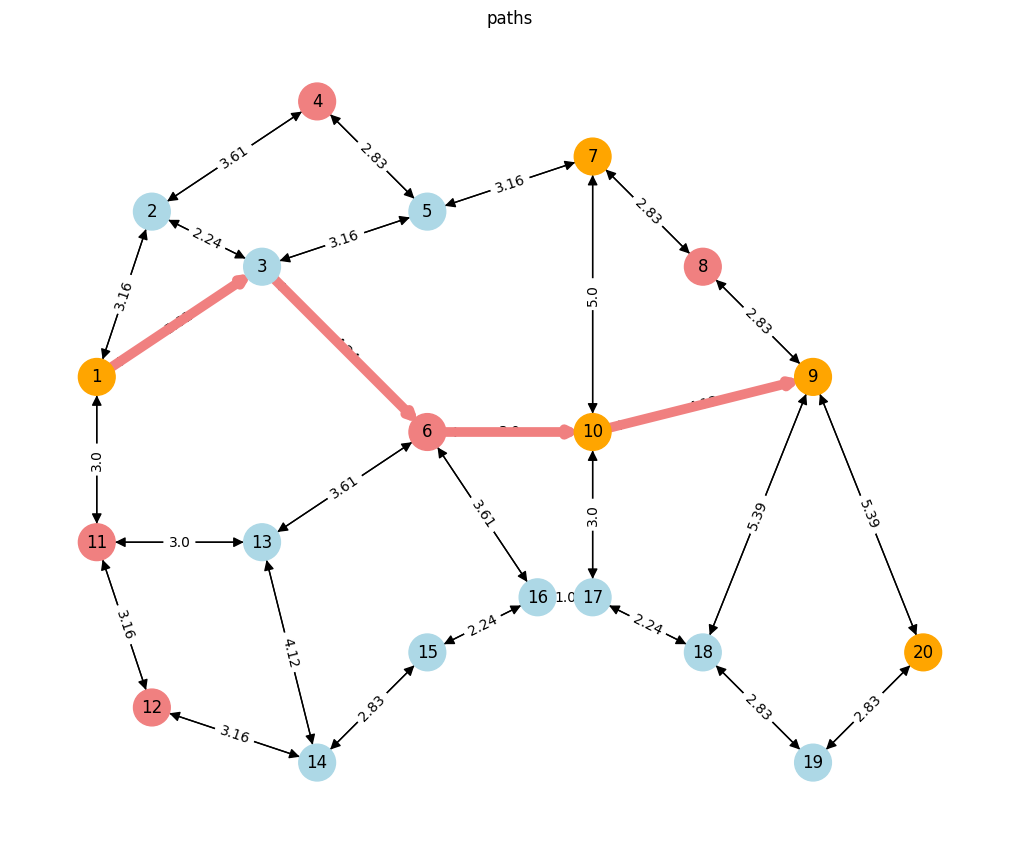

In [122]:

# Call function:
shortest_path_result, model, solving_time = shortest_path(
    model = ConcreteModel(),
    source = 1,
    destination = 9,
    node_positions= positions,
    arcs = connections,
    cost = edges,
    node_colors = node_colors,
    bool_print=True,
    plot_bool=True)

A Sensetivity analysis unfortunately yields no results, putting into question the existence of a dual problem. Since the shown shortest problem does not continiously adjustable constraints, the resulting sensetivities would however be in any case infeasable. In other words, flow continuity constraints can not be adjusted like for example the maximum available trains in the second part of this project. For the shortest path problem, the sensetivity analysis thus does not give any usable information.

In [123]:
model.dual = Suffix(direction=Suffix.IMPORT)
print("Sensitivity Analysis",display(model.dual))

dual : Direction=IMPORT, Datatype=FLOAT
    Key : Value
Sensitivity Analysis None


While the the shortest path problem was previously defined a continious problem, it is defacto an integer problem with this property previously enforced through the constraints. As one question might be how the performance of the solver develops with a growing number of nodes for the integer problem, a random network generator is set up and the shortest path function is modified to be a integer problem. The following code demonstrates the network generator and solves an examplory shortest path problem. 

length of shortest path:  9.22
Shortest Path Route (not sorted):
x[1,50]


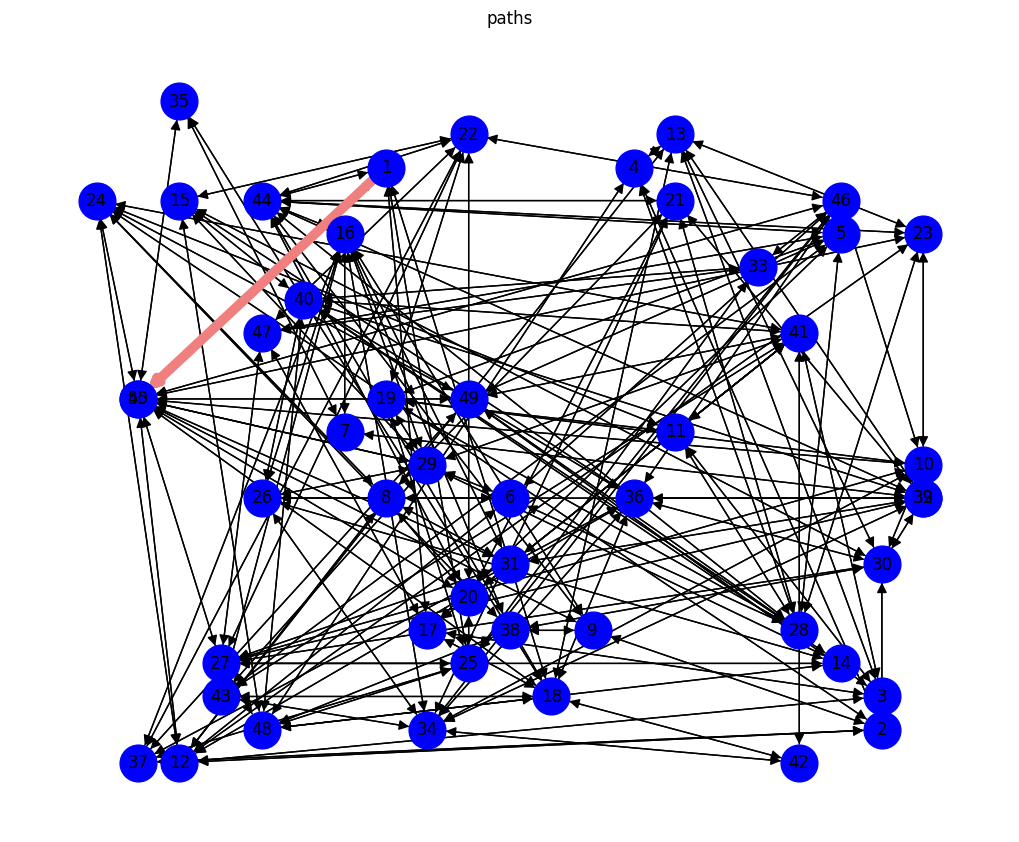

In [124]:
# Set up random network maker
def create_graph(n, grid_size=(20, 20)):

    # Set up outputs
    node_positions = {i: (random.randint(0, grid_size[0]), random.randint(0, grid_size[1])) for i in range(1, n+1)}
    arcs = []
    arc_costs = {}

    # Set up two arcs for each node
    for node in range(1, n+1):
        possible_connections = [i for i in range(1, n+1) if i != node]
        num_connections = random.randint(2, min(5, len(possible_connections)))  # Between 2 and 5 connections
        connections = random.sample(possible_connections, num_connections)

        # Add arcs in both directions and calculate costs (Eucledian distance)
        for connection in connections:
            x1, y1 = node_positions[node]
            x2, y2 = node_positions[connection]
            distance = round(math.sqrt((x2 - x1)**2 + (y2 - y1)**2), 2)  # Round to 2 decimal places

            arcs.append((node, connection))
            arc_costs[(node, connection)] = distance

            arcs.append((connection, node))
            arc_costs[(connection, node)] = distance

    return node_positions, arcs, arc_costs

### Example Usage

# Make Network
node_positions, arc_list, arc_cost_dict = create_graph(n=50)

# Solve shortest path problem
shortest_path_result, model, solving_time = shortest_path(
    model = ConcreteModel(),
    source = 1,
    destination = 50,
    node_positions= node_positions,
    arcs = arc_list,
    cost = arc_cost_dict,
    bool_print=True,
    plot_bool=True,
    edgelabel_bool=False)


Using the function to generate a random network and the shortest path function, the following code sets up an experiment for networks with n numbers of nodes as stores in n_nodes_list and solves 50 random shortest path problems within the network to average the time it took to solve them. The resulting percantage increase in solving time is shown in the resulting plot, indicating a somewhat gradual and not necessarily exponential increase in required compute time.

For n_nodes 20, average solving time after 10 repeats is 0.0389 seconds which is an increase in 38888129221.01 percent compared to previous step
For n_nodes 40, average solving time after 10 repeats is 0.0391 seconds which is an increase in 0.50 percent compared to previous step
For n_nodes 80, average solving time after 10 repeats is 0.0769 seconds which is an increase in 96.75 percent compared to previous step
For n_nodes 160, average solving time after 10 repeats is 0.0877 seconds which is an increase in 14.06 percent compared to previous step
For n_nodes 320, average solving time after 10 repeats is 0.1210 seconds which is an increase in 37.95 percent compared to previous step
For n_nodes 640, average solving time after 10 repeats is 0.2662 seconds which is an increase in 120.04 percent compared to previous step
For n_nodes 1280, average solving time after 10 repeats is 0.4998 seconds which is an increase in 87.72 percent compared to previous step


Text(0, 0.5, 'percentage increase of average solving time')

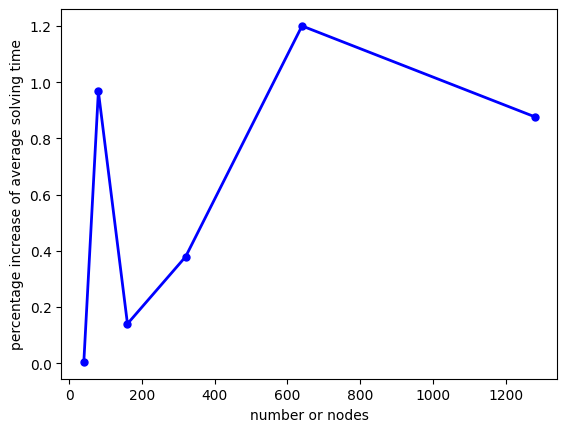

In [125]:
### THIS CODE CHUNK TAKES 1-5 MIN TO RUN !
#Make function to repeatetly solve shortest path problem for n_nodes and average solving time 
def eval_shortest_path_performance(n_nodes_list,repeats_per_n=50):
    # Set up vars
    mean_solving_time_old = 0.0000000001
    percentage_increase_solving_time_list = []

    # set up networks for n nodes
    for n_nodes in n_nodes_list:
        node_positions, arc_list, arc_cost_dict = create_graph(n=n_nodes)

        # solve shortest path problem n times 
        repeat = 0
        solving_time_list=[]
        while repeat <= repeats_per_n:
            shortest_path_result, model, solving_time = shortest_path(
                model = ConcreteModel(),
                source = random.randint(1, n_nodes),
                destination = random.randint(1, n_nodes),
                node_positions= node_positions,
                arcs = arc_list,
                cost = arc_cost_dict,
                x_var_type = NonNegativeIntegers,
                bool_print=False,
                plot_bool=False,
                edgelabel_bool=False)
            
            solving_time_list.append(solving_time)
            repeat = repeat+1

        # calc mean and percentage increase for solving time for n nodes
        mean_solving_time = statistics.mean(solving_time_list)
        percentage_increase_solving_time = (mean_solving_time/mean_solving_time_old)-1
        percentage_increase_solving_time_list.append(percentage_increase_solving_time)
        mean_solving_time_old = mean_solving_time

        # print
        print(f"For n_nodes {n_nodes}, average solving time after {repeats_per_n} repeats is {mean_solving_time:.4f} seconds which is an increase in {percentage_increase_solving_time*100:.2f} percent compared to previous step")
    
    return percentage_increase_solving_time_list

# Evaluate solving time for n nodes 
n_nodes_list=[20,40,80,160,320,640,1280]
percentage_increase_solving_time_list = eval_shortest_path_performance(n_nodes_list=n_nodes_list,repeats_per_n=10)

# Plot
plt.plot(n_nodes_list[1:], percentage_increase_solving_time_list[1:], color='blue', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.xlabel('number or nodes')
plt.ylabel('percentage increase of average solving time')


### Solving big Problem 

Having created a method that can be used to solve the shortest path problem, it is then used to solve the bigger optimization problem which is to distribute all node-to-node demands onto the arcs via their shortest connecting path. This is done by iterating over all nodes-to-node demands and adding the respective demands to the arcs of the shortest path connecting two nodes.

In [126]:
### Generate Arc Demands
arc_demand = {key: 0 for key in connections_demand.keys() if key in connections}
# iterate over nodes
for (source,destination) in connections_demand.keys():
    shortest_path_result,model,solving_time = shortest_path(
        model = ConcreteModel(),
        source = source,
        destination = destination,
        node_positions= positions,
        arcs = connections,
        cost = edges,
        bool_print=False,
        plot_bool=False,
        edgelabel_bool=False)
        # get results and add to existing demand on arc
    for (node_out,node_in) in shortest_path_result:
        arc_demand[(node_out,node_in)] = arc_demand[(node_out,node_in)] + connections_demand[(source,destination)]


The resuling demands can be vizualized as before to show how they are distributed.

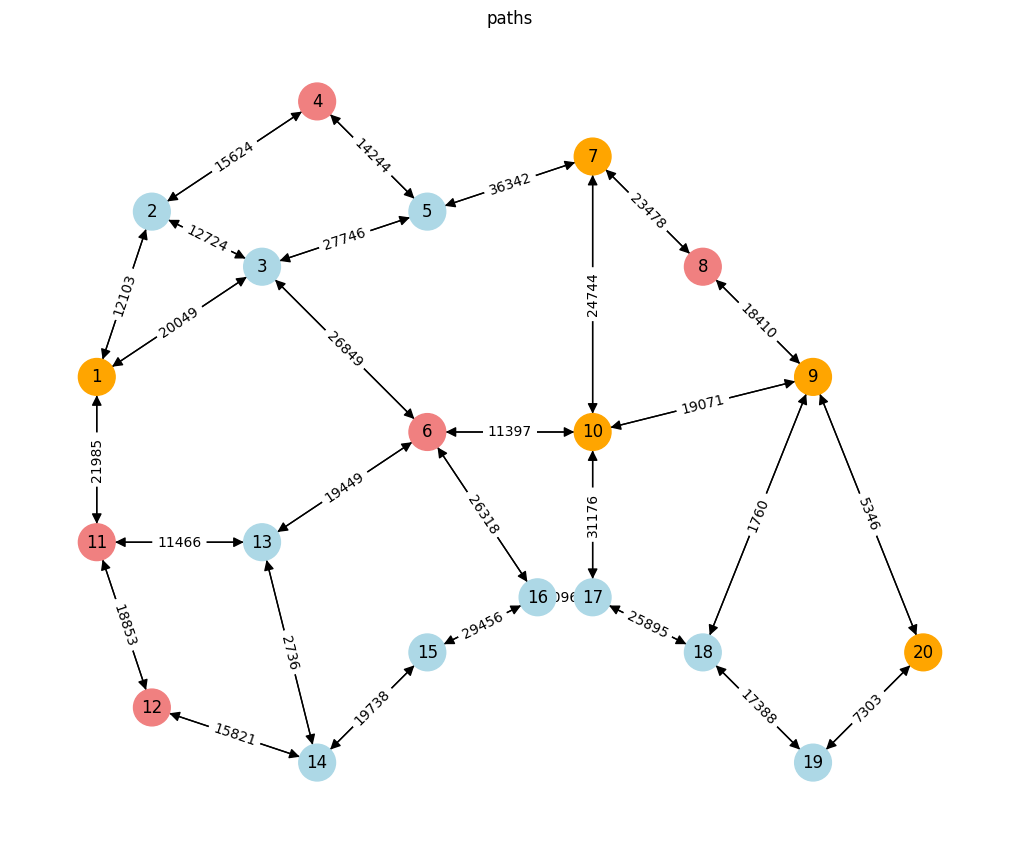

In [127]:
# Plot arc demands 
G_closest = nx.DiGraph()
G_closest.add_edges_from(connections)

plt.figure(figsize=(10, 8))
nx.draw(G_closest, pos=positions, with_labels=True, node_size=700, node_color=node_colors, arrowsize=15)
nx.draw_networkx_edge_labels(G_closest, pos=positions, edge_labels=arc_demand, font_size=10)

plt.title("paths")
plt.show()

# Part 2 - Lines

With the demands that each section of the network has to be able to fulfill identified, the second part of this work is regarding setting up a line network with optimal routing of lines and and equally optimal number of vehicles (space trains) moving along these lines. Lines are in this context defined as routes that space trains move along as a single journey, with an equal number of trains going both ways on each line for so to speak flow continiuity across the system (e.g. if 7 trains go on line A to B, the same amount of trains goes on the same line B to A). As in the first step demands have been reduced down to the arc level and depending on the line set up, to get from node 1 to node n requires the use of more than one line, it is assumed the schedule of trains going along these lines allows for switching between the respective lines/trains. These are the goals and the fundamental assumptions made for the optimization problems modeled in the following second part of this project.

## Modeling the joined Problem - Nonlinear Problem

Differently to the first section of this project where the question of arc demand was seperated from the overall problem of setting up a line network across nodes, in this second part an attempt was made to model the remaining drivers main drivers, line routing and number of trains in a single model. After extensive attempts were made, it modelling these two drivers together in a linear model was unsuccessfull. 

The subjective function of this nonlinear model revolves around modelling the cost of running all trainlines with the corresponding number of trains for each of the lines. In addition to that, a cost for each individual arc along which a given line is routed is added to calculate the total cost of running all lines and their respective trains. 

*Objective Function*: 

$min(\sum_{l=1}^{nlines} (fixcost+y_l\cdot costpertrain+\sum_{j=1}^{J}\sum_{i=1}^{I}x_{l;j,i}\cdot costperarc))$

s.t. 

*Demand Constraint:*

The constraint that makes this a nonlinear model is then introduced as the central oposing constraint on the balance between cost and required transport capacity. In this balance, the demand constraint sets a lower limit for capacity given by the respective demands on each arc. As the capactiy for a given arc is a product of the number of trains running along the given lines, the capacity of a given train and the binary variable of wether a train runs along a given route or not.

$demand_{i,j} \leq \sum_{l=1}^{nlines}y_l\cdot x_{l;j,i}$

*Flow Constraint:*

Line in the shortest path problem in the first part of this project, the established lines are also subject to flow continuity, the main main difference being that start and end node of the lines are now variable and are therefore limited to one start and one end node per line.

$\sum_{j:(i,j)}x_{l;i,j}+isstart_{l;i,j}=\sum_{j:(i,j)}x_{l;j,i}*+isend_{l;i,j}$

$\sum_{j:(i,j)}isstart_{l;i,j} = 1$

$\sum_{j:(i,j)}isend_{l;i,j} = 1$


*Max line length constraint*

As an additional constraint, the line length is limited to 7 arcs to indirectly introduce time into this model which otherwise does not include the aspect of journey duration.

$\sum_{j=1}^{J}\sum_{i=1}^{I}x_{l;j,i}=7$


The code as shown below was finished to a great extent but could not be used as pyomo does not support the nonlinear demand constraint.

In [128]:
    # NONLINEAR MODEL

def trainlines_nonlinear(arc_demand,
                         positions,
                         connections,
                         edges):

        # Set up model
        model_trainlines = ConcreteModel()

        # Network
        model_trainlines.nodes = Set(initialize=list(positions.keys()))  # Set of nodes
        model_trainlines.arcs = Set(within=model_trainlines.nodes*model_trainlines.nodes, initialize=connections)  # Set of arcs

        # Parameters
        model_trainlines.demand = Param(model_trainlines.arcs, initialize=arc_demand)  # Demand on arcs

        ## lines
        model_trainlines.cost_per_arc = Param(model_trainlines.arcs, initialize=edges)  # Cost of using an arc
        model_trainlines.cost_per_train_line = Param(initialize=400)  # Fixed cost per train line
        model_trainlines.max_lines = Param(initialize=10)  # Maximum possible train lines (upper bound)

        ## trains
        model_trainlines.max_trains_per_line = Param(initialize=15)
        model_trainlines.capacity_per_train = Param(initialize=5000)
        model_trainlines.cost_per_train = Param(initialize=100)
        model_trainlines.range_trains_per_line = RangeSet(1, model_trainlines.max_trains_per_line)


        # Decision Variables
        model_trainlines.lines = RangeSet(1, model_trainlines.max_lines) 
        model_trainlines.active_lines = Var(within=NonNegativeIntegers, bounds=(0, model_trainlines.max_lines)) 
        model_trainlines.x = Var(model_trainlines.lines, model_trainlines.arcs, within=NonNegativeIntegers)

        model_trainlines.is_start_node = Var(model_trainlines.lines, nodes, within=Binary)
        model_trainlines.is_end_node = Var(model_trainlines.lines, nodes, within=Binary)

        model_trainlines.active_trains_per_line = Var(model_trainlines.lines,within=NonNegativeIntegers, bounds=(0, model_trainlines.max_trains_per_line))  # Number of active train lines


        # Objective Rule
        def objective_rule_lines(model):
            cost = model.active_lines * model.cost_per_train_line \
                    + sum(model.cost_per_train * model_trainlines.active_trains_per_line[l] for l in model.lines) \
                + sum(model.cost_per_arc[i, j] * model.x[l, i, j] for l in model.lines for (i, j) in model.arcs)

            return cost
        model_trainlines.objective = Objective(rule=objective_rule_lines, sense=minimize)

        # Demand Constraint
        def demand_constr(model_trainlines, i, j):
            return model_trainlines.demand[i, j] <= sum(
                model_trainlines.active_trains_per_line[l] * model_trainlines.capacity_per_train * model_trainlines.x[l, i, j]
                for l in model_trainlines.lines
            ) 
        model_trainlines.demand_constraint = Constraint(model_trainlines.arcs, rule=demand_constr)

        # Proposal to linearize model

        # Flow cont constraints
        def flow_constr(model_trainlines,l):
            for node in model_trainlines.nodes:
                if node == model_trainlines.is_start_node:  # Source node
                    return ((sum(model_trainlines.x[l, i, node] for i in model_trainlines.nodes if (i, node) in model_trainlines.arcs) + sum(model_trainlines.x[l,node, j] for j in model_trainlines.nodes if (node, j) in model_trainlines.arcs)) == 1)
                elif node == model_trainlines.is_end_node:  # Destination node
                    return ((sum(model_trainlines.x[l, node, i] for i in model_trainlines.nodes if (node, i) in model_trainlines.arcs) + sum(model_trainlines.x[l,j, node] for j in model_trainlines.nodes if (j, node) in model_trainlines.arcs)) == 1)
                else:
                    return ((sum(model_trainlines.x[l, i, node] for i in model_trainlines.nodes if (i, node) in model_trainlines.arcs) == sum(model_trainlines.x[l,node, j] for j in model_trainlines.nodes if (node, j) in model_trainlines.arcs)))

        model_trainlines.flow_constr = Constraint(model_trainlines.lines, rule=flow_constr)

        def one_start_node_constr(model_trainlines, l):
            return sum(model_trainlines.is_start_node[l, node] for node in nodes) == 1
        model_trainlines.one_start_node_constr = Constraint(model_trainlines.lines, rule=one_start_node_constr)

        def one_end_node_constr(model_trainlines, l):
            return sum(model_trainlines.is_end_node[l, node] for node in nodes) == 1
        model_trainlines.one_end_node_constr = Constraint(model_trainlines.lines, rule=one_end_node_constr)

        # Max line length constraint
        def max_line_lenght(model_trainlines,l):
            return (sum(model_trainlines.x[l,i,j] for (i,j) in model_trainlines.arcs)) <= 8
        model_trainlines.line_lenght_constraint = Constraint(model_trainlines.lines, rule=max_line_lenght)

        # Solve 
        solver = SolverFactory('glpk')
        solver.solve(model_trainlines)

        return model_trainlines

# model = trainlines_nonlinear(arc_demand=arc_demand,
#                 positions = positions,
#                 connections=connections,
#                 edges=edges)
# model.pprint()


An attempt to linearize the model via a big M constraint decomposing the non-linear constraint into three linear constraint via a helper variable was unsuccessfull due to a contradiction in capacity constraint 2 and 3 as aparent in the code below.

In [129]:
# Big M Demand Constraint
# model_trainlines.z = Var(model_trainlines.lines, model_trainlines.arcs, within=NonNegativeReals)
# def capacity1(model_trainlines,i, j):
#     for l in model_trainlines.lines:
#         return model_trainlines.z[l,i,j] >= model_trainlines.active_trains_per_line[l] * model_trainlines.capacity_per_train
# model_trainlines.capacity1 = Constraint(model_trainlines.arcs, rule=capacity1)

# M = 10000000
# def capacity2(model_trainlines,i, j):
#     for l in model_trainlines.lines:
#         return model_trainlines.z[l,i,j] <= M*model_trainlines.x[l, i, j]
# model_trainlines.capacity2 = Constraint(model_trainlines.arcs, rule=capacity2)

# def capacity3(model_trainlines,i, j):
#     return model_trainlines.demand[i, j] <= sum(model_trainlines.z[l,i,j] for l in model_trainlines.lines) 
# model_trainlines.capacity3 = Constraint(model_trainlines.arcs, rule=capacity3)



## Simplified Problem

As the initial model to optimize line routing and train numbers to generate transport capacity along an network turned out to be nonlinear, an attempt was made to further seperate the overall problem into individual linear optimization problems. The two resulting identified problems are: 

- Line Routing Optimization
- Train Number Optimization (per line)

While both of these problems are modeled in the following section, only the train number optimization is implemented due to time constraints in this project. 

### Train Number Optimization

Goal of the train number optimization is to distribute an available number of trains optimally such that the amount of unfullfilled demand is minimized. The objective function to be minimized is thus defined the total sum of all arc demands minus the provided transport capactiy on the given arc through trains on one or more lines, with the condition of the substraction being either positive or 0 (as capacity > demand, simply leads to 100% demand being fullfilled)

$$\sum_{i,j=0}^{n}max(demand_{i,j}-\sum_{l=0}^{n_{lines}}traincapacity\cdot nTrains_l,0)$$

In addition to that, a constraint regarding the available number of trains limits the total number of trains deployed to the lines to a chosen number 

s.t.

$$\sum_{l=0}^{n_{lines}}nTrains_l <= nTrains_{max}$$

in practice, to implement specifically the objective function, a helper variable $y$ has to be introduced to enforce the $max(...,0)$ condition. Furthermore as the optimization problem for optimal line routing is not yet solved, a set of manually set up lines is used in the optimization. The function containing the model of the optimization problem is set up in the following. code 

In [130]:
# Optimize number of trains on line
def optimize_trains(nodes_as_list,
                    arcs,
                    arc_demand,
                    lines,
                    train_capacity,
                    max_trains_total,
                    x_var = NonNegativeIntegers,
                    print_bool = True):
    
    # Set up model
    model = ConcreteModel()

    # set up network
    model.nodes = Set(initialize=nodes_as_list)  # Set of nodes
    model.arcs = Set(within=model.nodes*model.nodes, initialize=arcs)  # Set of arcs
    model.demand = Param(model.arcs, initialize=arc_demand)  # Demand on arcs

    # set up lines (until avail via optimization)

    line_tuples = [(l, i, j) for l in lines for (i, j) in lines[l]]
    model.lines = Set(initialize=line_tuples, dimen=3)
    model.n_lines = Param(initialize=len(lines.keys()))
    model.lines_range = RangeSet(1, model.n_lines)
    model.max_trains_total=Param(initialize=max_trains_total)


    # Trains
    model.capacity_per_train = Param(initialize=train_capacity)
    #model.max_trains = Param(initialize=max_trains_per_line) 
    model.x = Var(model.lines_range,within=x_var)  # Number of active train lines

    # Aux var to garantuee non negative
    model.y = Var(model.arcs, within=NonNegativeReals)

    # obj function via aux variable
    def objective_rule_lines(model):
        return sum(model.y[i, j] for (i, j) in model.arcs)
    model.objective = Objective(rule=objective_rule_lines, sense=minimize)

    # demand2capacity delta i to j
    def unmet_demand_constraint(model, i, j):
        return model.y[i, j] >= model.demand[i, j] - sum(model.capacity_per_train * model.x[l] for l in model.lines_range if (l, i, j) in model.lines) 
    model.unmet_demand_constraint = Constraint(model.arcs, rule=unmet_demand_constraint)

    # demand2capacity delta j to i 
    def unmet_demand_constraint_reverse(model, j, i):
        return model.y[i, j] >= model.demand[j, i] - sum(model.capacity_per_train * model.x[l] for l in model.lines_range if (l, i, j) in model.lines) 
    model.unmet_demand_constraint_reverse = Constraint(model.arcs, rule=unmet_demand_constraint_reverse)

    def available_trains_constr(model):
        return sum(model.x[line] for line in model.lines_range) <= model.max_trains_total
    model.available_trains_constr = Constraint(rule = available_trains_constr)

    # Solve
    solver = SolverFactory('glpk')
    solver.solve(model)

    if print_bool:
        total_trains = 0
        for l in model.lines_range:
            if model.x[l].value is not None:
                print(f"Line {l} has {value(model.x[l])} active trains.")
                total_trains = total_trains+value(model.x[l])

        print(f"\nA total number of {total_trains} trains are in use")

    return model

For an manually chosen set of lines and using the arc demands evaluated in part 1, the optimization problem is solved for 50 available trains. Showing that 41 trains are required to fulfill all arc demands

In [131]:
lines = {
    1: [(11,1),(1, 3), (3, 5), (5, 7), (7, 8), (8, 9),(9,20),(20,19)],
    2: [(1, 3), (3, 6), (6, 16), (16, 17), (17, 18), (18, 19)],
    3: [(12,11),(11,1),(1,2),(2,4),(4,5)],
    4: [(11,13),(13,6),(6,10),(10,9)],
    5: [(7,10),(10,17),(17,16),(16,15),(15,14),(14,12)],
    6: [(13,14)],
    7: [(9,18)],
    8: [(2,3)],
}

model = optimize_trains(nodes_as_list=list(positions.keys()),
                        arcs = connections,
                        arc_demand=arc_demand,
                        lines = lines,
                        train_capacity = 5000,
                        max_trains_total = 50,
                        x_var = NonNegativeIntegers
                        )

Line 1 has 8.0 active trains.
Line 2 has 9.0 active trains.
Line 3 has 4.0 active trains.
Line 4 has 4.0 active trains.
Line 5 has 9.0 active trains.
Line 6 has 1.0 active trains.
Line 7 has 1.0 active trains.
Line 8 has 3.0 active trains.

A total number of 39.0 trains are in use


Investigating the free transport capacity on the individual arcs as shown in the visualisation in the plot below (number on arc indicates free, e.g. unused transport capacity) shows that free capacity is available on all arcs. Meanwhile, is is visible on every line, one arc serves as lower bound for the required number of trains and most times all other arcs experience significant overcapacity. This is a common problem in highly interconnected transportation networks like germanys (non-space) train network, limiting the maximum reachable efficency and making point to point connections in networks like spains high speed rail so cost-efficient. 

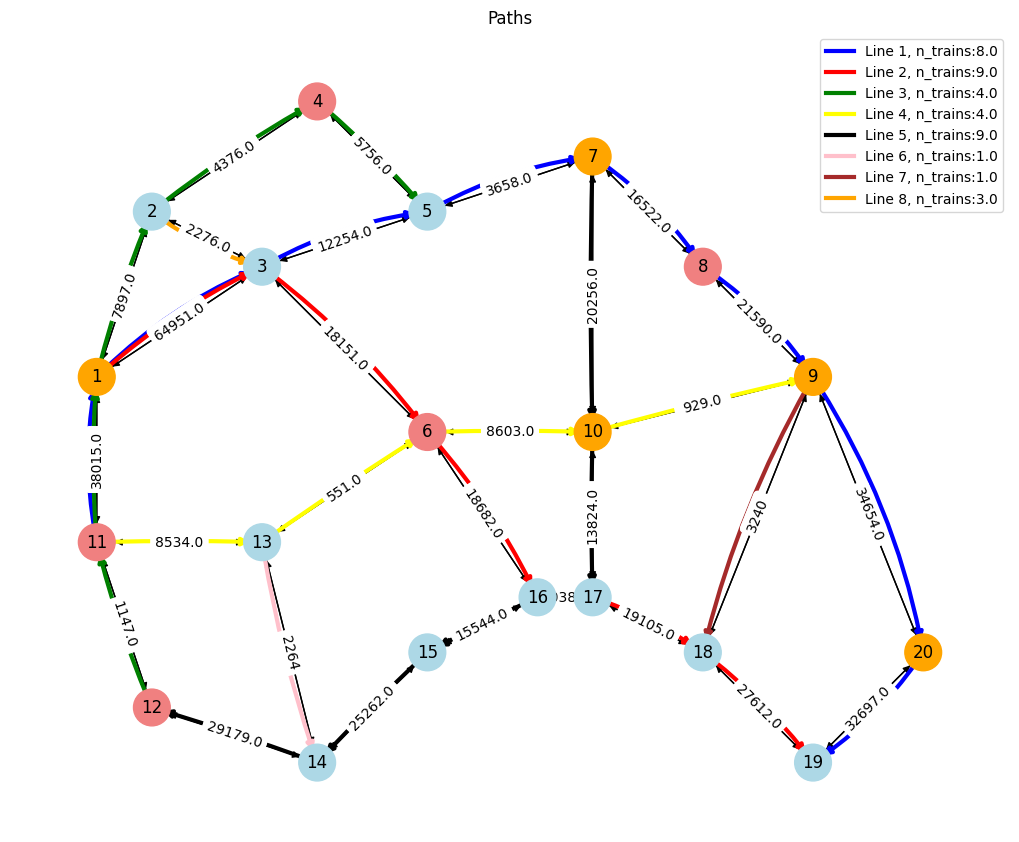

In [132]:
arc_capacity = {}
for (i, j) in model.arcs:
    total_capacity = 0
    for l in model.lines_range:
        if (l, i, j) in model.lines:
            total_capacity = total_capacity+ value(model.x[l]) * model.capacity_per_train
    arc_capacity[(i, j)] = total_capacity

for (i,j) in list(arc_capacity.keys()):
    if arc_capacity[(i,j)] == 0:
        arc_capacity[(i, j)] = arc_capacity[(j,i)]

line_colors = {
    1: 'blue', 
    2: 'red', 
    3: 'green',
    4: 'yellow',
    5: 'black',
    6: 'pink',
    7: 'brown',
    8: 'orange'
}

edge_labels = {(i, j): f"{arc_capacity[(i,j)] - arc_demand[(i,j)]}" for (i,j) in connections}

G_closest = nx.DiGraph()
G_closest.add_edges_from(connections) 

plt.figure(figsize=(10, 8))
nx.draw(G_closest, pos=positions, with_labels=True, node_size=700, node_color=node_colors)  



# Draw Lines with ofset
offsets = np.linspace(-0.1, 0.1, len(lines)) 
for idx, (line, edges) in enumerate(lines.items()):
    shifted_edges = []
    for (i, j) in edges:
        # Get pos
        x0, y0 = positions[i]
        x1, y1 = positions[j]
        
        # Apply offset
        dx, dy = x1 - x0, y1 - y0
        length = np.sqrt(dx**2 + dy**2)
        offset_x = offsets[idx] * dy / length
        offset_y = offsets[idx] * -dx / length

        shifted_edges.append(((x0 + offset_x, y0 + offset_y), (x1 + offset_x, y1 + offset_y)))

    # draw line
    nx.draw_networkx_edges(
        G_closest, 
        pos=positions, 
        edgelist=edges, 
        edge_color=line_colors[line], 
        width=3, 
        connectionstyle=f'arc3,rad={offsets[idx]}'  # curve the edge based on the offset
    )


nx.draw_networkx_edge_labels(G_closest, pos=positions, edge_labels=edge_labels, font_size=10)

# Create legend entries
legend_elements = [Line2D([0], [0], color=color, lw=3, label=f'Line {line}, n_trains:{model.x[line].value}') for line, color in line_colors.items()]
plt.legend(handles=legend_elements, loc='best')


plt.title("Paths")
plt.show()

With the problem being defined as integer problem, it is also possible to investigate the solution of the relaxed problem by changing the variable type to continious. The resulting values show that in most some cases, having two train sizes might improve efficency by having a second train type half as big to serve demand which currently required $x.5$ or lower demand.

In [133]:
# Solving relaxed Problem (x as continious)
model = optimize_trains(nodes_as_list=list(positions.keys()),
                        arcs = connections,
                        arc_demand=arc_demand,
                        lines = lines,
                        train_capacity = 5000,
                        max_trains_total = 40,
                        x_var = NonNegativeReals
                        )


# TODO: extrac dual
model.dual = Suffix(direction=Suffix.IMPORT)
print("Sensitivity Analysis",display(model.dual))


Line 1 has 7.3892 active trains.
Line 2 has 8.2518 active trains.
Line 3 has 3.8144 active trains.
Line 4 has 3.9504 active trains.
Line 5 has 8.2518 active trains.
Line 6 has 0.6168 active trains.
Line 7 has 0.352 active trains.
Line 8 has 2.6988 active trains.

A total number of 35.325199999999995 trains are in use
dual : Direction=IMPORT, Datatype=FLOAT
    Key : Value
Sensitivity Analysis None


Another interesting question is to investigate what happens when the number of avilable trains is limited to less then the number of trains required to fulfill the demand. Limiting the number of trains to 30, the result shows that minimizing the unfulfilled demand leads to no trains running on lines 6 and 7, which is in line with for example 7 only requiering 0.35 trains as shown in the relaxed solution. In this case, an additional constraint should be added as some other node to node connections may depend on these lines running and not servecing certain arcs at all may not be wanted.

In [134]:
model = optimize_trains(nodes_as_list=list(positions.keys()),
                    arcs = connections,
                    arc_demand=arc_demand,
                    lines = lines,
                    train_capacity = 5000,
                    max_trains_total = 30,
                    x_var = NonNegativeIntegers,
                    print_bool = True
                    )


Line 1 has 7.0 active trains.
Line 2 has 8.0 active trains.
Line 3 has 3.0 active trains.
Line 4 has 4.0 active trains.
Line 5 has 7.0 active trains.
Line 6 has 0.0 active trains.
Line 7 has 0.0 active trains.
Line 8 has 1.0 active trains.

A total number of 30.0 trains are in use


The relationship can be also vizualised showing how the objective function (amount of unmet demand) approaches a steady state of 0 as it the number of available trains increases. The optimal solution is identified at 39 as the with 39 trains the unmet demand hits zero and no further decrease is thus possible.

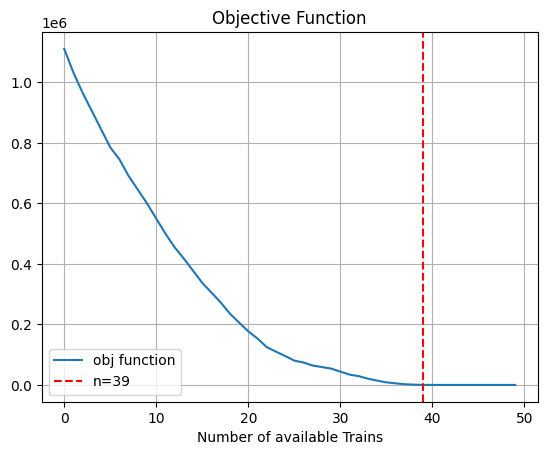

In [135]:

obj_list = []
max_trains_total_list = []
for max_trains_total in range(50):
    model = optimize_trains(nodes_as_list=list(positions.keys()),
                        arcs = connections,
                        arc_demand=arc_demand,
                        lines = lines,
                        train_capacity = 5000,
                        max_trains_total = max_trains_total,
                        x_var = NonNegativeIntegers,
                        print_bool = False
                        )

    # calculating unmet demand - recalculated due to complications with helper variable
    for (i, j) in model.arcs:
        total_capacity = 0
        for l in model.lines_range:
            if (l, i, j) in model.lines:
                total_capacity = total_capacity+ value(model.x[l]) * model.capacity_per_train
        arc_capacity[(i, j)] = total_capacity

    for (i,j) in list(arc_capacity.keys()):
        if arc_capacity[(i,j)] == 0:
            arc_capacity[(i, j)] = arc_capacity[(j,i)]

    unmet_demand = 0
    for (i, j) in model.arcs:
        unmet_demand = unmet_demand + max(arc_demand[(i,j)] -arc_capacity[(i,j)],0)
    
    obj_list.append(unmet_demand)
    max_trains_total_list.append(max_trains_total)


# plot
plt.plot(max_trains_total_list,obj_list,label="obj function")
plt.axvline(x=39, color='r', linestyle='--', label='n=39')


# Add labels and title
plt.xlabel('Number of available Trains')
plt.title('Objective Function')

plt.legend()
plt.grid()




Overall, the results of this model show some of the main issues of decupeling the line routing from the optimization of number of trains as significant overcapacity is a result of the current (manual) line routing. An attempt will be made to set up a model that can optimize line routing in the second part of the split problem. 

### Line Routing Optimization

As a brief last part of this project, a mathematical linear model is set up to optimize line routing among arcs seperately from the trains running on the resulting lines. With the learning from the previous train number optimization per line, the goal is to set up lines a minimum variance in arc demands along its route to archieve optimal capacity utilization for trains traveling along the line. The objective function to minimize is the sum of all Variances for all lines, e.g. 

$$\sum_{l}^{nlines}(\frac{1}{narcs_l-1} \sum_{i,j}^{nnodes}x_{i,j}\cdot (demand_{i,j}-meandemand_{l})^2)$$

with $narcs_l$ being the total number of arcs on the given line. The idea being to minimize both the variances itself as well as the absolut number of lines combine these two objectives into on objective function. As constraint a maximum line lenght is introduced as discussed in the nonlinear problem

s.t.

$(\sum_{j=1}^{J}\sum_{i=1}^{I}x_{l;j,i} )\leq 7$


*With the flow Constraints: as discussed in the nonlinear problem*

$\sum_{j:(i,j)}x_{l;i,j}+isstart_{l;i,j}=\sum_{j:(i,j)}x_{l;j,i}+isend_{l;i,j}$

$\sum_{j:(i,j)}isstart_{l;i,j} = 1$

$\sum_{j:(i,j)}isend_{l;i,j} = 1$

And every node neding at least one ingoing and one outgoing line connection

$\sum_{l=0}^{nlines}\sum_{j=0}^{nj} x_{node,j} \geq 1$

$\sum_{l=0}^{nlines}\sum_{i=0}^{ni} x_{i,node} \geq 1$





While this is a general idea on how the line routing might be modeled, it has to be further investigated if this a sensible approach as it again mixes two aspects (variance in demand and number of lines). Unfortunately the time restrictions on this project do not allow further investigation.

### Conclusion

The attempted linear modeling of the optimal transportation network problem via linear models, shows the limitations of linear models, specifically when it comes to interaction between multiple contributing factors. Each of the seperating steps into simpler problems has an inherent reduction in efficency as interactions between the variables of these sub-problems can no longer be used to find a global optimum. Assuming that all node to node demands take the most direct path reduces the solution space to these shortest paths while it might be more cost effective to increase capacity utilization of lines/trains instead of fulfilling demands via the shortest path. More complicated still is to seperate the interaction between line routing and trains running along them, as the interaction between the different lines and their respective number of trains (many lines and less trains per line vs few lines and many trains per line) is very much intertwined. In this case, there might be the possebility to further investigate linearization practices that might be able to allow modeling these two together as a linear problem as train routing is a binary optimization problem. Unfortuneatly due to time constraints, it is not possible to explore this further within this project.

In more general terms, the aspect of time has been nearly completely been ignored in the modeling done in this thesis, which for is a simplification that could not be made for time critical goods like passangers. This can be counted as the main simplification within this modelling work. 

Overall, a linera model or a composition of linear models might thus not be suited to solve this kind of transportation network problem, while further work in reformulation should be performed before permanently reaching this conclusion. In either case this work shows the limitations of linear model in complex and interdependent optimization problems. 